Test out OpenAI's Large Language Model (LLM) API

In [1]:
import openai
import os

key = os.environ.get('OPENAI_API_KEY')
openai.api_key = key

In [2]:
#print(key)

In [2]:
response = openai.Completion.create(
    engine="text-davinci-002",
    #engine="gpt-4",
    prompt="What is the capital of France?",
    max_tokens=1024,
    n=1,
    stop=None,
    temperature=0.5,
)

generated_text = response["choices"][0]["text"]
print(generated_text)

InvalidRequestError: The model: `gpt-4` does not exist

In [10]:
response

<OpenAIObject text_completion id=cmpl-73Z2QF7gPXyztdivs4bDqY0LdLkdA at 0x1f2564d3470> JSON: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "text": "\n\nParis"
    }
  ],
  "created": 1681084026,
  "id": "cmpl-73Z2QF7gPXyztdivs4bDqY0LdLkdA",
  "model": "text-davinci-002",
  "object": "text_completion",
  "usage": {
    "completion_tokens": 3,
    "prompt_tokens": 27,
    "total_tokens": 30
  }
}

In [7]:
response = openai.Completion.create(
    engine="text-davinci-002",
    prompt="What is the capital of France? Respond with only the capital. If the provided place has no captial, reply with 'None'",
    max_tokens=1024,
    n=1,
    stop=None,
    temperature=0.5,
)

generated_text = response["choices"][0]["text"]
print(generated_text)



Paris


Test out OpenAI's Whisper API - Voice to Text

In [8]:
# FindyBot5000-assets is a separate private github repo. Feel free to add your own assets by modifying the string below.
audio_file= open(r"..\FindyBot5000-assets\audio\test_inputs\FindyBot5000 test audio.mp3", "rb")
transcript = openai.Audio.transcribe("whisper-1", audio_file)

In [9]:
for k,v in transcript.items():
    print(k,v)

text Hello world, this is a test for a FindyBot 5000.


In [11]:
spoken_request = transcript['text']
print(spoken_request)

Hello world, this is a test for a FindyBot 5000.


Test Whisper + LLM. <br>
A spoken command will be along the lines of:<br>
"Hey FindyBot, I'm looking for red leds, can you give me a hand?"
1. Whisper will be used to parse Text from Audio
2. text-davinci LLM will be used to extract the relevant item from the query, in this case 'red led'

In [3]:
def return_searched_item(audio_path: str) -> tuple[str, str]:

    # Whisper
    leds_audio_file= open(audio_path, "rb")
    leds_transcript = openai.Audio.transcribe("whisper-1", leds_audio_file)
    leds_text = leds_transcript['text']

    # text-davinci LLM
    leds_response = openai.Completion.create(
        engine="text-davinci-002",
        prompt=f"Extract the item I am looking for from the following text. Respond with only the item. Make any plural words or acronyms in the response singular. Here is the text: '{leds_text}'",
        max_tokens=1024,
        n=1,
        stop=None,
        temperature=0.5,
    )

    leds_generated_text = leds_response["choices"][0]["text"]
    return leds_text, leds_generated_text


In [18]:
text, item = return_searched_item(r"..\FindyBot5000-assets\audio\test_inputs\red leds2.mp3")
print(text, item)

Hey Findy Bot, I'm looking for my red LEDs. Can you give me a hand? 

red LEDs


In [4]:
text, item = return_searched_item(r"..\FindyBot5000-assets\audio\test_inputs\AAA batteries.mp3")
print(text, item)

Hey, FinyBot, where are my AAA batteries? 

AAA batteries


Print speech components using PocketSphinx

In [1]:
from pocketsphinx import LiveSpeech
for phrase in LiveSpeech(): print(phrase)

okay testing one two three jarvis it
jarvis
a generous
a jarvis
jarvis
quick
quit


Here's a screenshot of speech recognition with Sphinx. It leaves a little something to be desired...<br>
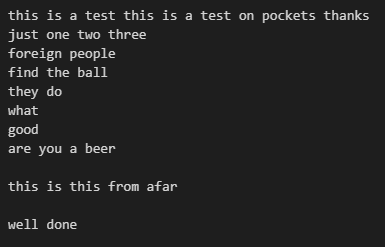

In [6]:
# Lets see how well keywords can be detected.
from pocketsphinx import LiveSpeech

speech = LiveSpeech(lm=False, keyphrase='jarvis', kws_threshold=1e-20)
for phrase in speech:
    print(phrase.segments(detailed=True))

# Jarvis won by a long shot over Aura, Lumen, Aria, Lyra, Zara

[('jarvis', -705, 79, 146)]
['jarvis']


In [6]:
import speech_recognition as sr

# Sphinx has some trouble getting 'jarvis' every time...
keywords = ['jarvis', 'jervis']

r = sr.Recognizer()
speech = sr.Microphone(device_index=0)

while True:
    # Listen for a sentence
    with speech as source:
        print("say something!…")
        audio = r.adjust_for_ambient_noise(source)
        audio = r.listen(source)
    
    # First try recognize speech using Sphinx, and search the string for any of the keywords
    # If a keyword is found, pass the raw audio to Whisper to perform full text recognition
    try:
        recognized_text = r.recognize_sphinx(audio)
        
        print("Sphinx thinks you said: '" + recognized_text + "'")

        if any(keyword in recognized_text.lower() for keyword in keywords):
            whisper_text = r.recognize_whisper_api(audio, model="whisper-1", api_key=key)
            print("Whisper thinks you said: '" + whisper_text + "'")

    except sr.UnknownValueError:
        print("Sphinx could not understand audio")  
    except sr.RequestError as e:  
        print("Sphinx error; {0}".format(e))

say something!…
Sphinx thinks you said: 'hey jervis where are my red annuities'
Whisper thinks you said: 'Hey Jarvis, where are my red LEDs?'
say something!…
Sphinx thinks you said: 'the jurors were my trip away batteries'
say something!…
Sphinx thinks you said: 'he jervis where are my triple a. batteries'
Whisper thinks you said: 'Hey Jarvis, where are my AAA batteries?'
say something!…


KeyboardInterrupt: 

Basic end to end example:
1. Listen for a spoken sentence
2. Use Sphinx to determine if the keyword was present
3. If so, use Whisper for speech-to-text
4. Use text-davinci to extract the item that the user is looking for
5. Next up... Synthesize voice from response text

In [ ]:
import speech_recognition as sr

# Sphinx has some trouble getting 'jarvis' every time...
keywords = ['jarvis', 'jervis']

r = sr.Recognizer()
speech = sr.Microphone(device_index=0)

while True:
    # Listen for a sentence
    with speech as source:
        print("Listening for a sentence...")
        audio = r.adjust_for_ambient_noise(source)
        audio = r.listen(source)
    
    # First try recognize speech using Sphinx, and search the string for any of the keywords
    # If a keyword is found, pass the raw audio to Whisper to perform full text recognition
    try:
        recognized_text = r.recognize_sphinx(audio)
        
        print(f"Sphinx thinks you said: '{recognized_text}'")

        # If a keyword wasn't found, go back to listening for input
        if not any(keyword in recognized_text.lower() for keyword in keywords):
            continue

        whisper_text = r.recognize_whisper_api(audio, model="whisper-1", api_key=key)
        print(f"Whisper thinks you said: '{whisper_text}'")
        
        # text-davinci LLM
        openai_response = openai.Completion.create(
            engine="text-davinci-002",
            prompt=f"Extract the item I am looking for from the following text. Respond with only the item. Make any plural words or acronyms in the response singular. Here is the text: '{whisper_text}'",
            max_tokens=1024,
            n=1,
            stop=None,
            temperature=0.5,
        )

        generated_text = openai_response["choices"][0]["text"]

        print(f"OpenAI thinks you are looking for: '{generated_text}'")

    except sr.UnknownValueError:
        print("Sphinx could not understand audio")  
    except sr.RequestError as e:  
        print("Sphinx error; {0}".format(e))

Hook into ElevenLabs API to synthesize voice

In [2]:
import os
elevenlabs_api_key = os.environ.get('ELEVENLABS_API_KEY')

In [ ]:
#print(elevenlabs_api_key)

In [22]:
from elevenlabslib import *

user = ElevenLabsUser(elevenlabs_api_key)
voice = user.get_voices_by_name("Rachel")[0]  # This is a list because multiple voices can have the same name

voice.play_preview(playInBackground=False)

voice.generate_and_play_audio("Test.", playInBackground=False)

for historyItem in user.get_history_items():
    if historyItem.text == "Test.":
        # The first items are the newest, so we can stop as soon as we find one.
        historyItem.delete()
        break

In [24]:
voice.generate_and_play_audio("Hello! I am Findy Bot, what are you looking for?", playInBackground=False)

Listen for keyword, then listen for sentence, then process text and generate output

In [9]:
import speech_recognition as sr
from pocketsphinx import LiveSpeech

r = sr.Recognizer()
speech = sr.Microphone(device_index=0)

# Step 1: Listen for the keyword
keyword_speech = LiveSpeech(lm=False, keyphrase='jarvis', kws_threshold=1e-20)
for phrase in keyword_speech:
    if phrase.segments()[0] == 'jarvis':
        break

# Step 2: Listen for a sentence
with speech as source:
    print("Listening for a sentence...")
    audio = r.adjust_for_ambient_noise(source)
    audio = r.listen(source)
    recognized_text = r.recognize_sphinx(audio)    
    print(f"Sphinx thinks you said: '{recognized_text}'")

Listening for a sentence...
Sphinx thinks you said: 'okay here's the sentence'


In [2]:
import openai
import os
import speech_recognition as sr
from pocketsphinx import LiveSpeech
from elevenlabslib import *

openai_key = os.environ.get('OPENAI_API_KEY')
openai.api_key = openai_key

elevenlabs_api_key = os.environ.get('ELEVENLABS_API_KEY')

# Sphinx has some trouble getting 'jarvis' every time...
keywords = ['jarvis', 'jervis']

r = sr.Recognizer()
speech = sr.Microphone(device_index=0)
user = ElevenLabsUser(elevenlabs_api_key)
voice = user.get_voices_by_name("Rachel")[0]  # This is a list because multiple voices can have the same name

quit = False

while not quit:
    # Step 0: Detect a human
    # todo

    try:
        # Step 1: Listen for the keyword
        #keyword_speech = LiveSpeech(lm=False, keyphrase='jarvis', kws_threshold=1e-20)
        keyword_speech = LiveSpeech()
        for phrase in keyword_speech:
            words = str(phrase)
            if any(keyword in words for keyword in keywords):# 'jarvis' in words or 'jervis' in words:
                break
            elif 'exit' in words:
                quit = True
                raise Exception("Quitting")

        # Step 2: Listen for a sentence
        with speech as source:
            print("Listening for a sentence...")
            audio = r.adjust_for_ambient_noise(source)
            audio = r.listen(source)
        
        # Step 3: Speech to Text
        print("Running speech to text with Whisper")
        whisper_text = r.recognize_whisper_api(audio, model="whisper-1", api_key=openai_key)
        print(f"Whisper thinks you said: '{whisper_text}'")
        
        # Step 4: Identify items from text using text-davinci LLM
        openai_response = openai.Completion.create(
            engine="text-davinci-002",
            prompt=f"Extract the item I am looking for from the following text. Respond with only the item. Make any plural words or acronyms in the response singular. Here is the text: '{whisper_text}'",
            max_tokens=1024,
            n=1,
            stop=None,
            temperature=0.5,
        )

        generated_text = openai_response["choices"][0]["text"].strip()

        print(f"OpenAI thinks you are looking for: '{generated_text}'")

        # Step 5: Use the whisper API to synthesize a voice response to the item being looked for
        voice.generate_and_play_audio(f"Great, I'll start looking for your {generated_text}", playInBackground=False)

    except sr.UnknownValueError:
        print("Sphinx could not understand audio")  
    except sr.RequestError as e:
        print("Sphinx error; {0}".format(e))
    except Exception as e:
        print(e)

Quitting


Example output:<br>
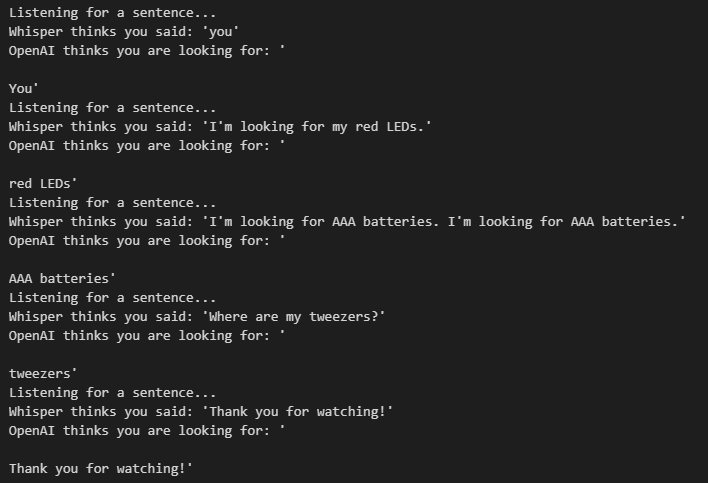

Using text-davinci to generate a friendly comment and a json encoding of the items to find in the same response. Time for some prompt engineering!

In [19]:
input_text = "Where are my green LEDs?"

prompt = \
    'A user will ask you to find, update the quantity of, or remove items. ' + \
    'Reply with a friendly message that mentions the items. The response should be a single sentence, followed by json. ' + \
    'If the user is finding an item, the json should be in the format: { "cmd": "find", "items": ["red LEDs", "blue LEDs"] }.' + \
    'If the user is updating the quantity of an item, the json should be in the format: { "cmd": "update", "item": "red LEDs", "quantity": 5 }.' + \
    'If the user is removing an item, the json should be in the format: { "cmd": "remove", "item": "red LEDs" }.' + \
    f'Text: {input_text}'

openai_response = openai.Completion.create(
    engine="text-davinci-003",
    prompt=prompt,
    max_tokens=1024,
    n=1,
    stop=None,
    temperature=0.5,
)

generated_text = openai_response["choices"][0]["text"].strip()

print(generated_text)

Sure thing, I'm looking for your green LEDs. { "cmd": "find", "items": ["green LEDs"] }


In [32]:
def get_response(question: str) -> str:

    prompt = \
        'A user will ask you to find, update the quantity of, or remove items. ' + \
        'Reply with a friendly message that mentions the items. The response should be a single sentence, followed by json. ' + \
        'If the user is finding an item, the json should be in the format: { "cmd": "find", "items": ["red LEDs", "blue LEDs"] }.' + \
        'If the user is updating the quantity of an item, the json should be in the format: { "cmd": "update", "item": "red LEDs", "quantity": 5 }.' + \
        'If the user is removing an item, the json should be in the format: { "cmd": "remove", "item": "red LEDs" }.' + \
        f'Text: {question}'

    openai_response = openai.Completion.create(
        engine="text-davinci-003",
        prompt=prompt,
        max_tokens=1024,
        n=1,
        stop=None,
        temperature=0.5,
    )

    generated_text = openai_response["choices"][0]["text"].strip()

    return prompt, generated_text

In [35]:
question = 'Add three green leds'

prompt, response = get_response(question)
print(response)

Sure thing! Here's the JSON: { "cmd": "update", "item": "green LEDs", "quantity": 3 }


In [33]:
question = 'Remove the blue LEDs'

prompt, response = get_response(question)
#print(prompt)
print(response)

.

Sure thing, I'm removing the blue LEDs. {"cmd": "remove", "item": "blue LEDs"}


In [34]:
question = 'I have four AAA batteries left'

prompt, response = get_response(question)
print(prompt)
print("----")
print(response)

A user will ask you to find, update the quantity of, or remove items. Reply with a friendly message that mentions the items. The response should be a single sentence, followed by json. If the user is finding an item, the json should be in the format: { "cmd": "find", "items": ["red LEDs", "blue LEDs"] }.If the user is updating the quantity of an item, the json should be in the format: { "cmd": "update", "item": "red LEDs", "quantity": 5 }.If the user is removing an item, the json should be in the format: { "cmd": "remove", "item": "red LEDs" }.Text: I have four AAA batteries left
----
and need to remove them from inventory.

Sure thing, I'll remove the AAA batteries from inventory. { "cmd": "remove", "item": "AAA batteries" }


This isn't working as well as I'd hoped.  Let's try using the ChatCompletion API and asking questions one at a time.

In [41]:
def get_chatcompletion_response(question: str) -> str:

    chat = [
        {"role": "user", "content": f'A user will ask you to find, add, or remove items. Reply with a friendly message that mentions the items. The response should be a single sentence. Question: {question}'}
    ]

    openai_response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=chat
    )

    language_response = openai_response["choices"][0]["message"]['content'].strip()

    chat.append(
    {
        "role": "assistant", 
        "content": language_response
    })
    
    chat.append(
    {
        "role": "user", 
        "content": 
            'Given the items from before, reply with json. ' + \
            'If finding items, format as: { "cmd": "find", "items": ["red LEDs", "blue LEDs"] }. ' + \
            'If adding items, format as: { "cmd": "add", "items": ["green LEDs", "AAA batteries"] }. ' + \
            'If removing items, format as: { "cmd": "remove", "items": ["yellow LEDs", "twist ties"] }.'
    })

    print(chat)

    openai_response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=chat
    )

    json_response = openai_response["choices"][0]["message"]['content'].strip()

    return language_response, json_response

In [43]:
lang, json = get_chatcompletion_response("where are my green LEDs?")

print(lang)
print(json)

[{'role': 'user', 'content': 'A user will ask you to find, add, or remove items. Reply with a friendly message that mentions the items. The response should be a single sentence. Question: where are my green LEDs?'}, {'role': 'assistant', 'content': 'Let me check where your green LEDs are located.'}, {'role': 'user', 'content': 'Given the items from before, reply with json. If finding items, format as: { "cmd": "find", "items": ["red LEDs", "blue LEDs"] }. If adding items, format as: { "cmd": "add", "items": ["green LEDs", "AAA batteries"] }. If removing items, format as: { "cmd": "remove", "items": ["yellow LEDs", "twist ties"] }.'}]
Let me check where your green LEDs are located.
{ "cmd": "find", "items": ["green LEDs"] }


Try two separate requests:

In [64]:
def get_responses(question: str) -> str:

    engine = "text-davinci-003"

    language_prompt = \
        'You are a helpful assistant. A user will ask you to find, add, or remove items. Assume all items can be found.' + \
        'Reply with a friendly message. The message must mention the items. Do not mention where the items are added or removed. It must be a single sentence.' + \
        f'Question: {question}'

    openai_response = openai.Completion.create(
        engine=engine,
        prompt=language_prompt,
        max_tokens=1024,
        n=1,
        stop=None,
        temperature=0.5,
    )

    language_response = openai_response["choices"][0]["text"].strip()

    json_prompt = \
        'You are a helpful assistant. You are asked to find, add, or remove items. Reply with json only. ' + \
        'If finding items, format as: { "cmd": "find", "items": ["red LEDs", "blue LEDs"] }. ' + \
        'If adding items, format as: { "cmd": "add", "items": ["green LEDs"] }. ' + \
        'If removing items, format as: { "cmd": "remove", "items": ["yellow LEDs", "twist ties", "9V battery"] }.' + \
       f'Question: {question}'
    
    openai_response = openai.Completion.create(
        engine=engine,
        prompt=json_prompt,
        max_tokens=1024,
        n=1,
        stop=None,
        temperature=0.5,
    )

    json_response = openai_response["choices"][0]["text"].strip()

    return language_response, json_response

In [59]:
question = 'Add some blue LEDs'

spoken_reply, json_reply = get_responses(question)
print(f"{spoken_reply=}")
print(f"{json_reply=}")

spoken_reply="I'll be happy to add some blue LEDs for you."
json_reply='{ "cmd": "add", "items": ["blue LEDs"] }'


In [60]:
question = 'Add some blue LEDs, a 9V battery, and some twist ties'

spoken_reply, json_reply = get_responses(question)
print(spoken_reply)
print("----")
print(json_reply)

I will add the blue LEDs, 9V battery, and twist ties for you.
----
{ "cmd": "add", "items": ["blue LEDs", "9V battery", "twist ties"] }


In [61]:
question = 'find my multimeter'

spoken_reply, json_reply = get_responses(question)
print(spoken_reply)
print("----")
print(json_reply)

I'll help you find your multimeter.
----
{ "cmd": "find", "items": ["multimeter"] }


In [62]:
question = 'delete my mini breadboard'

spoken_reply, json_reply = get_responses(question)
print(spoken_reply)
print("----")
print(json_reply)

No problem, I'll take care of deleting your mini breadboard.
----
{"cmd": "remove", "items": ["mini breadboard"]}


In [65]:
question = 'where is my electrical tape?'

spoken_reply, json_reply = get_responses(question)
print(spoken_reply)
print("----")
print(json_reply)

I can help you find your electrical tape.
----
{ "cmd": "find", "items": ["electrical tape"] }


Design a SQL table to store items

In [83]:
import sqlite3

conn = sqlite3.connect("inventory.db")
cursor = conn.cursor()

# Create the item_inventory table
cursor.execute("""
CREATE TABLE IF NOT EXISTS item_new (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    name TEXT NOT NULL UNIQUE,
    quantity INTEGER NOT NULL DEFAULT 1,
    row INTEGER NOT NULL,
    col INTEGER NOT NULL,
    date_created DATETIME NOT NULL,
    date_updated DATETIME NOT NULL
)
""")

# Commit the changes and close the connection
conn.commit()

In [84]:
# Copy over items to a new table
conn = sqlite3.connect("inventory.db")
cursor = conn.cursor()

cursor.execute("""
INSERT INTO item_new (id, name, quantity, row, col, date_created, date_updated)
SELECT id, name, quantity, row, col, date_created, date_updated
FROM item
"""
)

conn.commit()
conn.close()

In [85]:
conn = sqlite3.connect("inventory.db")
cursor = conn.cursor()

# Drop the old items table
cursor.execute("DROP TABLE item")

# Rename the item_new to item
cursor.execute("ALTER TABLE item_new RENAME TO item")

conn.commit()
conn.close()

In [86]:
conn = sqlite3.connect("inventory.db")
cursor = conn.cursor()

# Query all tables in the database
cursor.execute("SELECT name FROM sqlite_master WHERE type='table'")

# Fetch the table names
tables = cursor.fetchall()

# Iterate through the table names and print the schema for each table
print("Schemas of tables:")
for table in tables:
    table_name = table[0]
    cursor.execute(f"PRAGMA table_info('{table_name}')")
    schema = cursor.fetchall()
    
    print(f"\nTable: {table_name}")
    print("---------------------------------------------------")
    print("Column ID | Column Name  | Column Type | Nullable | Default Value | Primary Key")
    
    for column in schema:
        default_value = 'None' if column[4] is None else column[4]
        print(f"{column[0]:<9} | {column[1]:<12} | {column[2]:<11} | {column[3]:<8} | {default_value:<13} | {column[5]:<11}")

# Close the connection
conn.close()

Schemas of tables:

Table: sqlite_sequence
---------------------------------------------------
Column ID | Column Name  | Column Type | Nullable | Default Value | Primary Key
0         | name         |             | 0        | None          | 0          
1         | seq          |             | 0        | None          | 0          

Table: item
---------------------------------------------------
Column ID | Column Name  | Column Type | Nullable | Default Value | Primary Key
0         | id           | INTEGER     | 0        | None          | 1          
1         | name         | TEXT        | 1        | None          | 0          
2         | quantity     | INTEGER     | 1        | 1             | 0          
3         | row          | INTEGER     | 1        | None          | 0          
4         | col          | INTEGER     | 1        | None          | 0          
5         | date_created | DATETIME    | 1        | None          | 0          
6         | date_updated | DATETIME    |

In [105]:
def print_item_table():
    conn = sqlite3.connect("inventory.db")
    cursor = conn.cursor()

    cursor.execute("SELECT * FROM item")
    items = cursor.fetchall()

    print("Items in the table:")
    print(f"{'ID':<4} | {'Name':<15} | {'Quantity':<8} | {'Row':<4} | {'Col':<6} | {'Date Created':<12} | {'Date Updated':<16}")
    print("-----------------------------------------------------------------------------")
    
    for item in items:
        print(f"{item[0]:<4} | {item[1]:<15} | {item[2]:<8} | {item[3]:<4} | {item[4]:<6} | {item[5]:<12} | {item[6]:<16}")

    conn.close()

In [95]:
import sqlite3
from datetime import date

def add_or_update_item(item_name, additional_quantity):
    conn = sqlite3.connect("inventory.db")
    cursor = conn.cursor()

    # Check if the item already exists
    cursor.execute("SELECT * FROM item WHERE name = ?", (item_name,))
    item = cursor.fetchone()

    if item:
        # Item exists, update its quantity
        new_quantity = item[2] + additional_quantity
        cursor.execute("UPDATE item SET quantity = ?, date_updated = ? WHERE name = ?",
                       (new_quantity, date.today(), item_name))
    else:
        # Item does not exist, find the next available row and column
        cursor.execute("SELECT MAX(row), MAX(col) FROM item")
        max_row, max_column = cursor.fetchone()

        if max_column is None or max_row is None:
            next_row = 1
            next_column = 1
        elif max_column < 10:
            next_row = max_row
            next_column = max_column + 1
        else:
            next_row = max_row + 1
            next_column = 1

        # Insert the new item with the given quantity at the next available row and column
        cursor.execute("""
            INSERT INTO item (name, quantity, row, col, date_created, date_updated)
            VALUES (?, ?, ?, ?, ?, ?)
            """, (item_name, additional_quantity, next_row, next_column, date.today(), date.today()))

    # Commit the changes and close the connection
    conn.commit()
    conn.close()

In [107]:
add_or_update_item("Red LED", 5)

In [109]:
add_or_update_item("9V Battery", 1)

In [110]:
print_item_table()

Items in the table:
ID   | Name            | Quantity | Row  | Col    | Date Created | Date Updated    
-----------------------------------------------------------------------------
1    | Red LED         | 10       | 1    | 1      | 2023-04-11   | 2023-04-11      
2    | 9V Battery      | 1        | 1    | 2      | 2023-04-11   | 2023-04-11      


Test out full text search in SQLite

In [88]:
conn = sqlite3.connect("inventory.db")
cursor = conn.cursor()

cursor.execute("DROP TABLE IF EXISTS item")
cursor.execute("DROP TABLE IF EXISTS item_fts")

conn.commit()
conn.close()

In [1]:
import sqlite3
from datetime import date

def create_tables():
    conn = sqlite3.connect("inventory.db")
    cursor = conn.cursor()

    cursor.execute("""
        CREATE TABLE IF NOT EXISTS item (
            id INTEGER PRIMARY KEY,
            name TEXT UNIQUE NOT NULL,
            quantity INTEGER NOT NULL DEFAULT 1,
            row INTEGER NOT NULL,
            col INTEGER NOT NULL,
            date_created DATE NOT NULL,
            date_updated DATE NOT NULL
        )
    """)

    cursor.execute("""
        CREATE VIRTUAL TABLE IF NOT EXISTS item_fts USING fts5(id, name, tokenize='porter');
    """)

    conn.commit()
    conn.close()

create_tables()

In [5]:
def add_or_update_item(item_name, additional_quantity):
    conn = sqlite3.connect("inventory.db")
    cursor = conn.cursor()

    # Check if the item already exists
    cursor.execute("SELECT * FROM item WHERE name = ?", (item_name,))
    item = cursor.fetchone()

    if item:
        # Item exists, update its quantity
        new_quantity = item[2] + additional_quantity
        cursor.execute("UPDATE item SET quantity = ?, date_updated = ? WHERE name = ?",
                       (new_quantity, date.today(), item_name))
    else:
        # Item does not exist, find the next available row and column
        cursor.execute("SELECT MAX(row), MAX(col) FROM item")
        max_row, max_column = cursor.fetchone()

        if max_column is None or max_row is None:
            next_row = 1
            next_column = 1
        elif max_column < 10:
            next_row = max_row
            next_column = max_column + 1
        else:
            next_row = max_row + 1
            next_column = 1

        # Insert the new item with the given quantity at the next available row and column
        cursor.execute("""
            INSERT INTO item (name, quantity, row, col, date_created, date_updated)
            VALUES (?, ?, ?, ?, ?, ?)
            """, (item_name, additional_quantity, next_row, next_column, date.today(), date.today()))
        
        cursor.execute("""
            INSERT INTO item_fts (id, name)
            VALUES (?, ?)
            """, (cursor.lastrowid, item_name))

    # Commit the changes and close the connection
    conn.commit()
    conn.close()

In [6]:
add_or_update_item("9V battery", 1)
add_or_update_item("9V batteries", 1)
add_or_update_item("White LED", 1)
add_or_update_item("Green LEDs", 1)
add_or_update_item("Red LEDs", 5)

In [7]:
def search_items(query):
    conn = sqlite3.connect("inventory.db")
    cursor = conn.cursor()

    cursor.execute("SELECT item.*, item_fts.rank FROM item JOIN item_fts ON item.id = item_fts.id WHERE item_fts.name MATCH ? ORDER BY item_fts.rank", (query,))
    results = cursor.fetchall()

    print(f"Search results for '{query}':")
    for result in results:
        print(f"ID: {result[0]}, Name: {result[1]}, Relevance Score: {result[-1]}")

    conn.close()

In [9]:
def search_items(query):
    conn = sqlite3.connect("inventory.db")
    cursor = conn.cursor()

    cursor.execute("SELECT item.*, item_fts.rank FROM item JOIN item_fts ON item.id = item_fts.id WHERE item_fts.name MATCH ? ORDER BY item_fts.rank", (query,))
    results = cursor.fetchall()

    print(f"Search results for '{query}':")
    for result in results:
        print(result)

    conn.close()

In [10]:
# Perform a full-text search on the name column
search_items("battery")

Search results for 'battery':
(1, '9V battery', 2, 1, 1, '2023-04-12', '2023-04-13', -0.9388131867648212)
(9, '9V batteries', 1, 1, 8, '2023-04-13', '2023-04-13', -0.9388131867648212)


In [37]:
search_items("led")

Search results for 'led':
ID: 3, Name: White LED, Relevance Score: -1e-06
ID: 4, Name: Green LEDs, Relevance Score: -1e-06
ID: 5, Name: Red LEDs, Relevance Score: -1e-06


In [38]:
search_items('leds')

Search results for 'leds':
ID: 3, Name: White LED, Relevance Score: -1e-06
ID: 4, Name: Green LEDs, Relevance Score: -1e-06
ID: 5, Name: Red LEDs, Relevance Score: -1e-06


In [91]:
def delete_items(items):
    conn = sqlite3.connect("inventory.db")
    cursor = conn.cursor()

    for item in items:
        cursor.execute(f"DELETE FROM item WHERE name=?", (item,))

        if cursor.rowcount > 0:
            print(f"'{item}' deleted from the item table.")
        else:
            print(f"'{item}' not found in the item table.")

        cursor.execute(f"DELETE FROM item_fts WHERE name=?", (item,))
        
        if cursor.rowcount > 0:
            print(f"'{item}' deleted from the item_fts table.")
        else:
            print(f"'{item}' not found in the item_fts table.")

    conn.commit()
    conn.close()

In [61]:
def print_tables():
    conn = sqlite3.connect("inventory.db")
    cursor = conn.cursor()

    cursor.execute("SELECT * FROM item")
    items = cursor.fetchall()

    print("Item table:")
    print(f"{'ID':<4} | {'Name':<15} | {'Quantity':<8} | {'Row':<4} | {'Col':<6} | {'Date Created':<12} | {'Date Updated':<16}")
    print("-----------------------------------------------------------------------------")
    
    for item in items:
        print(f"{item[0]:<4} | {item[1]:<15} | {item[2]:<8} | {item[3]:<4} | {item[4]:<6} | {item[5]:<12} | {item[6]:<16}")


    print()
    print("Item FTS table:")
    cursor.execute("SELECT * FROM item_fts")
    rows = cursor.fetchall()

    if not rows:
        print("The item_fts table is empty.")
    else:
        print(f"{'ID':<4} {'Name':<30}")
        print("-" * 40)
        for row in rows:
            print(f"{row[0]:<4} {row[1]:<30}")

    conn.close()

In [64]:
print_tables()

Item table:
ID   | Name            | Quantity | Row  | Col    | Date Created | Date Updated    
-----------------------------------------------------------------------------
2    | 9V batteries    | 5        | 1    | 2      | 2023-04-12   | 2023-04-12      
3    | White LED       | 4        | 1    | 3      | 2023-04-12   | 2023-04-12      
4    | Green LEDs      | 3        | 1    | 4      | 2023-04-12   | 2023-04-12      
5    | Red LEDs        | 15       | 1    | 5      | 2023-04-12   | 2023-04-12      
6    | 9V battery      | 1        | 1    | 6      | 2023-04-12   | 2023-04-12      

Item FTS table:
ID   Name                          
----------------------------------------
2    9V batteries                  
3    White LED                     
4    Green LEDs                    
5    Red LEDs                      
6    9V battery                    


In [65]:
delete_items(["9V battery"])

'9V battery' deleted from the item table.
'9V battery' deleted from the item_fts table.


In [69]:
print_tables()

Item table:
ID   | Name            | Quantity | Row  | Col    | Date Created | Date Updated    
-----------------------------------------------------------------------------
2    | 9V batteries    | 5        | 1    | 2      | 2023-04-12   | 2023-04-12      
3    | White LED       | 4        | 1    | 3      | 2023-04-12   | 2023-04-12      
4    | Green LEDs      | 3        | 1    | 4      | 2023-04-12   | 2023-04-12      
5    | Red LEDs        | 15       | 1    | 5      | 2023-04-12   | 2023-04-12      

Item FTS table:
ID   Name                          
----------------------------------------
2    9V batteries                  
3    White LED                     
4    Green LEDs                    
5    Red LEDs                      


Modify the add or update method to account for row/column pairs that have become available when an item has been deleted

In [90]:
def add_or_update_item(item_name, additional_quantity):
    conn = sqlite3.connect("inventory.db")
    cursor = conn.cursor()

    # Check if the item already exists
    cursor.execute("SELECT * FROM item WHERE name = ?", (item_name,))
    item = cursor.fetchone()

    if item:
        # Item exists, update its quantity
        new_quantity = item[2] + additional_quantity
        cursor.execute("UPDATE item SET quantity = ?, date_updated = ? WHERE name = ?",
                       (new_quantity, date.today(), item_name))
    else:
        # Item does not exist, find the next available row and column
        # Query all rows and columns in the item table
        cursor.execute("SELECT row, col FROM item")
        occupied_positions = cursor.fetchall()

        # Determine the minimum available row and column
        occupied_positions_set = set(occupied_positions)
        if len(occupied_positions_set) > 0:
            max_row = max([pos[0] for pos in occupied_positions])
            max_col = max([pos[1] for pos in occupied_positions])
        else:
            max_row, max_col = 0, 0

        next_row, next_column = None, None
        for row in range(1, min(max_row + 2, 8)):
            for col in range(1, min(max_col + 2, 16)):
                if (row, col) not in occupied_positions_set:
                    next_row, next_column = row, col
                    break
            if next_row is not None:
                break

        if next_row == None or next_column == None:
            raise Exception("There is no remaining space in the organizer!")
        
        print(f"Inserting item '{item_name}' at [{next_row}, {next_column}]")

        # Insert the new item with the given quantity at the next available row and column
        cursor.execute("""
            INSERT INTO item (name, quantity, row, col, date_created, date_updated)
            VALUES (?, ?, ?, ?, ?, ?)
            """, (item_name, additional_quantity, next_row, next_column, date.today(), date.today()))
        
        cursor.execute("""
            INSERT INTO item_fts (id, name)
            VALUES (?, ?)
            """, (cursor.lastrowid, item_name))

    # Commit the changes and close the connection
    conn.commit()
    conn.close()

In [92]:
add_or_update_item("9V battery", 1)
add_or_update_item("9V batteries", 1)
add_or_update_item("Green LEDs", 1)
add_or_update_item("Red LEDs", 1)
add_or_update_item("White LED", 1)
print_tables()

Inserting item '9V battery' at [1, 1]
Inserting item '9V batteries' at [1, 2]
Inserting item 'Green LEDs' at [1, 3]
Inserting item 'Red LEDs' at [1, 4]
Inserting item 'White LED' at [1, 5]
Item table:
ID   | Name            | Quantity | Row  | Col    | Date Created | Date Updated    
-----------------------------------------------------------------------------
1    | 9V battery      | 1        | 1    | 1      | 2023-04-12   | 2023-04-12      
2    | 9V batteries    | 1        | 1    | 2      | 2023-04-12   | 2023-04-12      
3    | Green LEDs      | 1        | 1    | 3      | 2023-04-12   | 2023-04-12      
4    | Red LEDs        | 1        | 1    | 4      | 2023-04-12   | 2023-04-12      
5    | White LED       | 1        | 1    | 5      | 2023-04-12   | 2023-04-12      

Item FTS table:
ID   Name                          
----------------------------------------
1    9V battery                    
2    9V batteries                  
3    Green LEDs                    
4    Red LEDs  

In [93]:
delete_items(["Red LED", "9V batteries"])
print_tables()

'Red LED' not found in the item table.
'Red LED' not found in the item_fts table.
'9V batteries' deleted from the item table.
'9V batteries' deleted from the item_fts table.
Item table:
ID   | Name            | Quantity | Row  | Col    | Date Created | Date Updated    
-----------------------------------------------------------------------------
1    | 9V battery      | 1        | 1    | 1      | 2023-04-12   | 2023-04-12      
3    | Green LEDs      | 1        | 1    | 3      | 2023-04-12   | 2023-04-12      
4    | Red LEDs        | 1        | 1    | 4      | 2023-04-12   | 2023-04-12      
5    | White LED       | 1        | 1    | 5      | 2023-04-12   | 2023-04-12      

Item FTS table:
ID   Name                          
----------------------------------------
1    9V battery                    
3    Green LEDs                    
4    Red LEDs                      
5    White LED                     


In [94]:
add_or_update_item("twist ties", 1)
add_or_update_item("mini breadboard", 1)
print_tables()

Inserting item 'twist ties' at [1, 2]
Inserting item 'mini breadboard' at [1, 6]
Item table:
ID   | Name            | Quantity | Row  | Col    | Date Created | Date Updated    
-----------------------------------------------------------------------------
1    | 9V battery      | 1        | 1    | 1      | 2023-04-12   | 2023-04-12      
3    | Green LEDs      | 1        | 1    | 3      | 2023-04-12   | 2023-04-12      
4    | Red LEDs        | 1        | 1    | 4      | 2023-04-12   | 2023-04-12      
5    | White LED       | 1        | 1    | 5      | 2023-04-12   | 2023-04-12      
6    | twist ties      | 1        | 1    | 2      | 2023-04-12   | 2023-04-12      
7    | mini breadboard | 1        | 1    | 6      | 2023-04-12   | 2023-04-12      

Item FTS table:
ID   Name                          
----------------------------------------
1    9V battery                    
3    Green LEDs                    
4    Red LEDs                      
5    White LED                     
6  

In [95]:
add_or_update_item("speaker", 1)
print_tables()

Inserting item 'speaker' at [1, 7]
Item table:
ID   | Name            | Quantity | Row  | Col    | Date Created | Date Updated    
-----------------------------------------------------------------------------
1    | 9V battery      | 1        | 1    | 1      | 2023-04-12   | 2023-04-12      
3    | Green LEDs      | 1        | 1    | 3      | 2023-04-12   | 2023-04-12      
4    | Red LEDs        | 1        | 1    | 4      | 2023-04-12   | 2023-04-12      
5    | White LED       | 1        | 1    | 5      | 2023-04-12   | 2023-04-12      
6    | twist ties      | 1        | 1    | 2      | 2023-04-12   | 2023-04-12      
7    | mini breadboard | 1        | 1    | 6      | 2023-04-12   | 2023-04-12      
8    | speaker         | 1        | 1    | 7      | 2023-04-12   | 2023-04-12      

Item FTS table:
ID   Name                          
----------------------------------------
1    9V battery                    
3    Green LEDs                    
4    Red LEDs                      
5

Put everything together.<br>
1. PocketSphinx listens for the keyword
2. PocketSphinx captures the next spoken sentence
3. Whisper converts speech to text
4. GPT extracts relevant parts of text, and responds with a sentence
5. ElevenLabs synthesizes a voice for the sentence
6. GPT extracts relevant json from Whisper's text
7. SQLite handles item insertion, updating, deletion, and searching in the database.

Test GPT-3.5-Turbo vs. text-davinci-003

In [4]:
question = "Where are my red LEDS and my 9V battery?"

language_prompt = \
    'You are a helpful assistant. A user will ask you to find, add, or remove items. Assume all items can be found.' + \
    'Reply with a friendly message. The message must mention the items. If there are no items, reply with an empty sentence. ' + \
    'Do not mention where the items are added or removed. It must be a single sentence.' + \
    f'Question: {question}'

engine = "text-davinci-003"

response = openai.Completion.create(
    engine=engine,
    prompt=language_prompt,
    max_tokens=1024,
    n=1,
    stop=None,
    temperature=0.5,
)

generated_text = response["choices"][0]["text"]
print(generated_text)

InvalidRequestError: This is a chat model and not supported in the v1/completions endpoint. Did you mean to use v1/chat/completions?

In [12]:
messages=[
        {"role": "system", "content": 
            'You are a helpful assistant. A user will ask you to find, add, or remove items. Assume all items can be found.' + \
            'Reply with a friendly message. The message must mention the items. If there are no items, reply with an empty sentence. ' + \
            'Do not mention where the items are added or removed. It must be a single sentence.'},
        {"role": "user", "content": question}
    ]

model = "gpt-3.5-turbo"
#model = "gpt-4"

response = openai.ChatCompletion.create(
    model=model,
    messages=messages
)

print(response['choices'][0]['message']['content'])

print(response)

I will find your red LEDs and 9V battery for you.
{
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "message": {
        "content": "I will find your red LEDs and 9V battery for you.",
        "role": "assistant"
      }
    }
  ],
  "created": 1681411451,
  "id": "chatcmpl-74wDT2GciqcDmx0kaX7oMwGvt35u0",
  "model": "gpt-3.5-turbo-0301",
  "object": "chat.completion",
  "usage": {
    "completion_tokens": 14,
    "prompt_tokens": 96,
    "total_tokens": 110
  }
}


In [14]:
messages=[
        {"role": "system", "content": 
            'You are a helpful assistant. A user will ask you to find, add, or remove items. Assume all items can be found.' + \
            'Reply with a friendly message. The message must mention the items. If there are no items, reply with an empty sentence. ' + \
            'Do not mention where the items are added or removed. It must be a single sentence.'},
        {"role": "user", "content": question}
    ]

model = "gpt-3.5-turbo"
#model = "gpt-4"

response = openai.ChatCompletion.create(
    model=model,
    messages=messages
)

print(response['choices'][0]['message']['content'])
print(response)

messages.append(response['choices'][0]['message'])
messages.append({
    "role": "user",
    "content": 
        'Reply with json only. ' + \
        'If finding items, format as: { "cmd": "find", "items": ["red LEDs", "blue LEDs"] }. ' + \
        'If adding items, format as: { "cmd": "add", "items": ["green LEDs"] }. ' + \
        'If removing items, format as: { "cmd": "remove", "items": ["yellow LEDs", "twist ties", "9V battery"]' 
    })

response = openai.ChatCompletion.create(
    model=model,
    messages=messages
)

print(response['choices'][0]['message']['content'])
print(response)

I'll help you locate your red LEDs and 9V battery right away!
{
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "message": {
        "content": "I'll help you locate your red LEDs and 9V battery right away!",
        "role": "assistant"
      }
    }
  ],
  "created": 1681411689,
  "id": "chatcmpl-74wHJdD82QOJK2FSzXcOfiJXGCm7s",
  "model": "gpt-3.5-turbo-0301",
  "object": "chat.completion",
  "usage": {
    "completion_tokens": 16,
    "prompt_tokens": 96,
    "total_tokens": 112
  }
}
{ "cmd": "find", "items": ["red LEDs", "9V battery"] }
{
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "message": {
        "content": "{ \"cmd\": \"find\", \"items\": [\"red LEDs\", \"9V battery\"] }",
        "role": "assistant"
      }
    }
  ],
  "created": 1681411690,
  "id": "chatcmpl-74wHKNRHwoD2HJxXYfkmzYvkQ6sXT",
  "model": "gpt-3.5-turbo-0301",
  "object": "chat.completion",
  "usage": {
    "completion_tokens": 20,
    "prompt_tokens"